## Compare observed and synthetic phase curves

In [1]:
import shutil
import warnings
from datetime import datetime
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.const import init_const
from aeolus.plot import add_custom_legend, subplot_label_generator
from aeolus.synthobs import calc_stellar_flux, read_spectral_bands

In [3]:
from util_commons import PLANETS, SUITES
from util_mypaths import path_to_constants, path_to_datasets, path_to_results, path_to_observations
from util_plot_func import use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
use_paper_style()

In [5]:
def calc_star_planet_separation_angle(star_radius, planet_semi_major_axis):
    """Calculate the star-planet separation angle [degrees], which is the angle between (a) and (b), where
    (a) secondary eclipse, i.e., when a star eclipses a planet and star-planet centers are aligned, and
    (b) angle, when a maximum area of the planetary dayside is visible to the observer before or after (a).
    Formula: $\theta=\arcsin(\frac{R_{star}}{a})$"""
    universal = init_const("universal", directory=path_to_constants)

    star_planet_separation_angle = np.rad2deg(
        np.arcsin(star_radius.data / (planet_semi_major_axis.data * universal.au.data))
    )
    return star_planet_separation_angle

In [6]:
# Parameters
metallicity = "1x solar"

hatp11b_const = init_const("hatp11b", directory=path_to_constants)
hd189733b_const = init_const("hd189733b", directory=path_to_constants)
hd209458b_const = init_const("hd209458b", directory=path_to_constants)
wasp17b_const = init_const("wasp17b", directory=path_to_constants)
PLANET_CONSTS = [hatp11b_const, hd189733b_const, hd209458b_const, wasp17b_const]

### Calculate phase curves from the UM

In [7]:
# Read spectral bands from the SOCRATES spectral file
# (band numbering and bounds are the same for HAT-P-11b, HD 189733b, HD 209458b and WASP-17b)
path_to_star_spectrum_lw = SUITES["hatp11b"]["equilibrium"][metallicity]["dir_for_star_spectrum_lw"]
socrates_bands = read_spectral_bands(path_to_star_spectrum_lw)
# SOCRATES bands corresponding to the center of the Spitzer/IRAC 3.6, 4.5, 5.8 and 8.0 micrometer channels,
# and an extra band for 10.5 micrometers containing an NH3 feature
# Wavelength range of average spectral response curves for the Spitzer/IRAC 3.6, 4.5, 5.8 and 8.0 micrometer channels
# https://irsa.ipac.caltech.edu/data/SPITZER/docs/irac/calibrationfiles/spectralresponse/
BANDS = {
    "3.6": {
        "species": "ch4",
        "color": "C3",
        "index": 278,
        "bounds_socrates": (socrates_bands[277][1], socrates_bands[277][2]),
        "bounds_spitzer_irac": (3.081060, 4.010380),
    },
    "4.5": {
        "species": "co",
        "color": "C1",
        "index": 223,
        "bounds_socrates": (socrates_bands[222][1], socrates_bands[222][2]),
        "bounds_spitzer_irac": (3.722490, 5.221980),
    },
    "5.8": {
        "species": "h2o",
        "color": "C0",
        "index": 173,
        "bounds_socrates": (socrates_bands[172][1], socrates_bands[172][2]),
        "bounds_spitzer_irac": (4.744210, 6.622510),
    },
    "8.0": {
        "species": "ch4",
        "color": "darkred",
        "index": 125,
        "bounds_socrates": (socrates_bands[124][1], socrates_bands[124][2]),
        "bounds_spitzer_irac": (6.151150, 9.728750),
    },
    "10.5": {
        "species": "nh3",
        "color": "C5",
        "index": 96,
        "bounds_socrates": (socrates_bands[95][1], socrates_bands[95][2]),
        "bounds_spitzer_irac": (socrates_bands[95][1] * 1e6, socrates_bands[95][2] * 1e6),
    },
}

# Find spectral band centers
path_to_spectral_file = SUITES["hatp11b"]["equilibrium"][metallicity]["dir_for_star_spectrum_sw"]
spectral_bands = read_spectral_bands(path_to_spectral_file)
spectral_band_centers = 0.5 * (
    spectral_bands["lower_wavelength_limit"] + spectral_bands["upper_wavelength_limit"]
)

# Mask SOCRATES bands in a way that covers the range of the Spitzer/IRAC channels
for band, band_dict in BANDS.items():
    band_dict["mask_for_spitzer_irac"] = (
        spectral_band_centers >= band_dict["bounds_spitzer_irac"][0] * 1e-6
    ) & (spectral_band_centers <= band_dict["bounds_spitzer_irac"][1] * 1e-6)
    print(band, band_dict["bounds_spitzer_irac"], band_dict["mask_for_spitzer_irac"].sum())

3.6 (3.08106, 4.01038) 76
4.5 (3.72249, 5.22198) 78
5.8 (4.74421, 6.62251) 60
8.0 (6.15115, 9.72875) 60
10.5 (10.416666555101983, 10.52631614584243) 1


In [8]:
# Calculate phase curves for the Spitzer/IRAC channels and 10.5 micrometers
vrbls = {}
for planet, planet_const in tqdm(zip(PLANETS.keys(), PLANET_CONSTS)):
    vrbls[planet] = {}
    for exp in tqdm(["equilibrium", "kinetics"]):
        vrbls[planet][exp] = {}
        # Load data
        star_constant_at_1_au = planet_const.star_constant_at_1_au
        path_to_spectral_file = SUITES[planet][exp][metallicity]["dir_for_star_spectrum_sw"]
        path_to_phase_curves = SUITES[planet][exp][metallicity][f"dir_for_phase_curves"]
        # SW EMISSION SPECTRUM
        sw_planet_flux = iris.load_cube(str(path_to_phase_curves), "m01s01i713")
        # LW EMISSION SPECTRUM
        lw_planet_flux = iris.load_cube(str(path_to_phase_curves), "m01s02i713")
        # Calculate stellar flux
        stellar_flux = calc_stellar_flux(path_to_spectral_file, star_constant_at_1_au)
        # Calculate planetary flux as a sum of the shortwave and longwave emission across the planet
        sw_planet_flux_sum = sw_planet_flux.collapsed(["latitude", "longitude"], iris.analysis.SUM)
        lw_planet_flux_sum = lw_planet_flux.collapsed(["latitude", "longitude"], iris.analysis.SUM)
        planet_flux = sw_planet_flux_sum + lw_planet_flux_sum
        planet_flux.coord("pseudo_level").rename("spectral_band_index")

        for band in BANDS.keys():
            vrbls[planet][exp][band] = {}
            stellar_flux_by_band = stellar_flux[BANDS[band]["mask_for_spitzer_irac"], :].collapsed(
                "spectral_band_index",
                iris.analysis.SUM,
            )
            planet_flux_by_band = planet_flux[BANDS[band]["mask_for_spitzer_irac"], :].collapsed(
                "spectral_band_index",
                iris.analysis.SUM,
            )
            # Divide the planetary flux by the stellar flux
            phase_curve = planet_flux_by_band / stellar_flux_by_band
            # Assemble data
            vrbls[planet][exp][band] = {
                "phase_curve": phase_curve,
            }

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# Find star-planet separation angles
thetas = {}
for planet, planet_const in zip(PLANETS.keys(), PLANET_CONSTS):
    star_planet_separation_angle = calc_star_planet_separation_angle(
        planet_const.star_radius, planet_const.planet_semi_major_axis
    )
    thetas[planet] = {"star_planet_separation_angle": star_planet_separation_angle}
thetas

{'hatp11b': {'star_planet_separation_angle': 3.4616338231995294},
 'hd189733b': {'star_planet_separation_angle': 6.388682667512781},
 'hd209458b': {'star_planet_separation_angle': 6.533274226136118},
 'wasp17b': {'star_planet_separation_angle': 8.240204604688666}}

In [10]:
# Reconstruct output phase angles
phase_angs_w_theta = {}
for planet in PLANETS.keys():
    # Choosen phase angles
    phase_angs_dummy = [
        180,  # dummy for 180-theta
        180,  # secondary eclipse
        180,  # dummy for 180+theta
        210,
        240,
        270,
        300,
        330,
        360,
        390,
        420,
        450,
        480,
        510,
        540,  # secondary eclipse
    ]
    phase_angs_w_theta[planet] = {}
    phase_angs = phase_angs_dummy
    phase_angs[0] = phase_angs_dummy[0] - thetas[planet]["star_planet_separation_angle"]
    phase_angs[2] = phase_angs_dummy[2] + thetas[planet]["star_planet_separation_angle"]
    phase_angs_w_theta[planet] = {"phase_angs": phase_angs}

### Organise observational data

In [11]:
# From Maria Steinrueck and Heather Knutson
import scipy.io
from matplotlib.ticker import AutoMinorLocator

datapath = str(path_to_observations / "hd189733b_Knutson2012")

# markerprops = {
#     "markersize": 2,
#     "markeredgecolor": "skyblue",
#     "zorder": 1,
# }  # for 3.6, 4.5, 8 micron data
# markerprops_agol = {
#     "markersize": 2,
#     "markeredgecolor": "skyblue",
#     "zorder": 1,
#     "fillstyle": "none",
# }  # for 8 micron data agol
# markerprops2 = {
#     "markersize": 4,
#     "markeredgecolor": "skyblue",
#     "color": "skyblue",
#     "linewidth": 2,
# }  # for 24 micron data

# Read in parameters
channel = [5, 6, 8, 10]  # band for which the phasecurves are plotted %5=3.6 microns, 6=4.5 microns
chname = ["3.6 \mum", "4.5 \mum", "8 \mum  ", "24 \mum "]

# fig, axarr = plt.subplots(2, 2, sharex=True)
# plotlines = []

# Read in Knutson et al 2012 data
# 3.6 microns
a = scipy.io.readsav(datapath + "/final_lg_bin_ch1_phot.sav")
binphase = a["binphase"]
binflux = a["binflux"]

ii = np.where(np.abs(binphase - 0.5) < 0.01)  # if during secondary eclipse
binflux = binflux / np.mean(binflux[ii]) - 1.0  # normalize
binphase = binphase - 0.5  # change phase such that secondary eclipse is at zero
ii = np.where(binphase < -0.5)
binphase[ii] = binphase[ii] + 1
knutson2012_36_x = binphase * 360
knutson2012_36_y = binflux * 1e2
# axarr[0, 0].plot(binphase * 360, binflux * 1e2, "o", fillstyle="none", **markerprops)

# 4.5 microns
a = scipy.io.readsav(datapath + "/final_lg_bin_ch2_phot.sav")
binphase = a["binphase"]
binflux = a["binflux"]

ii = np.where(np.abs(binphase - 0.5) < 0.01)  # if during secondary eclipse
binflux = binflux / np.mean(binflux[ii]) - 1.0  # normalize
binphase = binphase - 0.5  # change phase such that secondary eclipse is at zero
ii = np.where(binphase < -0.5)
binphase[ii] = binphase[ii] + 1
knutson2012_45_x = binphase * 360
knutson2012_45_y = binflux * 1e2
# axarr[0, 1].plot(binphase * 360, binflux * 1e2, "o", fillstyle="none", **markerprops)

# 8 microns
npts = 495
phase = np.zeros(npts)
flux = np.zeros(npts)

file = open(datapath + "/final_binned_data_8um.txt", "r")
file.readline()

i = 0
for line in file:
    columns = line.split()
    phase[i] = float(columns[0])
    flux[i] = float(columns[1])
    i += 1
file.close()

ii = np.searchsorted(phase * 360, 70)
time = (phase - 0.5) * 2.21857578 * 24
stellar_flux = time * 0.000024
flux = flux - stellar_flux

phase = phase - 0.5
# axarr[1, 0].plot(phase[ii::] * 360, (flux[ii::] - 1) * 1e2, "o", fillstyle="none", **markerprops)

a = scipy.io.readsav(datapath + "/phase_function_data.sav")
agol_phase = a["dt"] / 2.21857578 + 0.5
agol_degr = agol_phase * 360
agol_flux = a["fobs"]
ii = np.logical_and(agol_flux > -0.015, agol_flux < 0.02)
agol_degr = agol_degr[ii] - 180
agol_flux = agol_flux[ii]

nrb = agol_degr.shape[0] // 1800
agol_degr_rb = np.zeros(nrb)
agol_flux_rb = np.zeros(nrb)

for i in range(nrb):
    j = i * 1800
    agol_degr_rb[i] = np.average(agol_degr[j : j + 1800])
    agol_flux_rb[i] = np.average(agol_flux[j : j + 1800])

knutson2012_80_x = agol_degr_rb
knutson2012_80_y = agol_flux_rb * 1e2

# axarr[1, 0].plot(agol_degr_rb, agol_flux_rb * 1e2, "o", **markerprops_agol)

# 24 microns
npts = 6
phase24 = np.zeros(npts)
flux24 = np.zeros(npts)
err24 = np.zeros(npts)

file = open(datapath + "/large_bin_data_final_24um.txt", "r")
file.readline()

i = 0
for line in file:
    columns = line.split()
    phase24[i] = float(columns[0])
    flux24[i] = float(columns[1])
    err24[i] = float(columns[2])
    i += 1
file.close()

ii = np.where(phase24 < 0.0)
time = (phase24 - 0.5) * 2.21857578 * 24
stellar_flux = time * 0.000013
flux24 = flux24 - stellar_flux

phase24 = phase24 - 0.5
phase24[ii] = phase24[ii] + 1

# axarr[1, 1].errorbar(
#     phase24 * 360,
#     (flux24 - 1) * 1e2,
#     yerr=err24 * 1e2,
#     marker="o",
#     linestyle="none",
#     fillstyle="none",
#     **markerprops2
# )

# adding axis labels etc
# axarr[0, 1].yaxis.tick_right()
# axarr[1, 1].yaxis.tick_right()

# for i in range(2):
#     for j in range(2):
#         axarr[i, j].xaxis.set_minor_locator(AutoMinorLocator(3))
#         axarr[i, j].yaxis.set_minor_locator(AutoMinorLocator(5))

#         axarr[i, j].xaxis.set_ticks_position("both")
#         axarr[i, j].yaxis.set_ticks_position("both")


# axarr[1, 0].set_xlabel("phase angle [deg]")
# axarr[1, 1].set_xlabel("phase angle [deg]")
# axarr[0, 0].set_ylabel("$F_p/F_*$ [%]")
# axarr[1, 0].set_ylabel("$F_p/F_*$ [%]")

# axarr[0, 0].set_title("3.6 $\mu m$")
# axarr[0, 1].set_title("4.5 $\mu m$")
# axarr[1, 0].set_title("8 $\mu m$")
# axarr[1, 1].set_title("24 $\mu m$")

# axarr[0, 0].set_xlim([-180, 180])
# axarr[0, 0].set_xticks([-180, -90, 0, 90, 180])


# axarr[0, 0].set_ylim([0, 0.20])
# axarr[0, 1].set_ylim([0.05, 0.25])

# fig.tight_layout()

In [12]:
# Zellem2014 4.5 micrometers phase curve fit
def zellem2014_phase_curve_fit(phase):
    phase_curve_fit = (
        9.81 * 1e-4 - 0.0410 * 1e-2 * np.cos(phase) + 0.0354 * 1e-2 * np.sin(phase)
    )  # * 1e2  # \pm 0.0123\times 10^{-2}
    return phase_curve_fit


plt_zellem2014_phase_curve_fit = [
    zellem2014_phase_curve_fit(i) for i in np.deg2rad(np.arange(0, 359))
]

plt_zellem2014_phase_curve_fit_minus = [i - 0.0123 * 1e-2 for i in plt_zellem2014_phase_curve_fit]
plt_zellem2014_phase_curve_fit_plus = [i + 0.0123 * 1e-2 for i in plt_zellem2014_phase_curve_fit]

### Compare

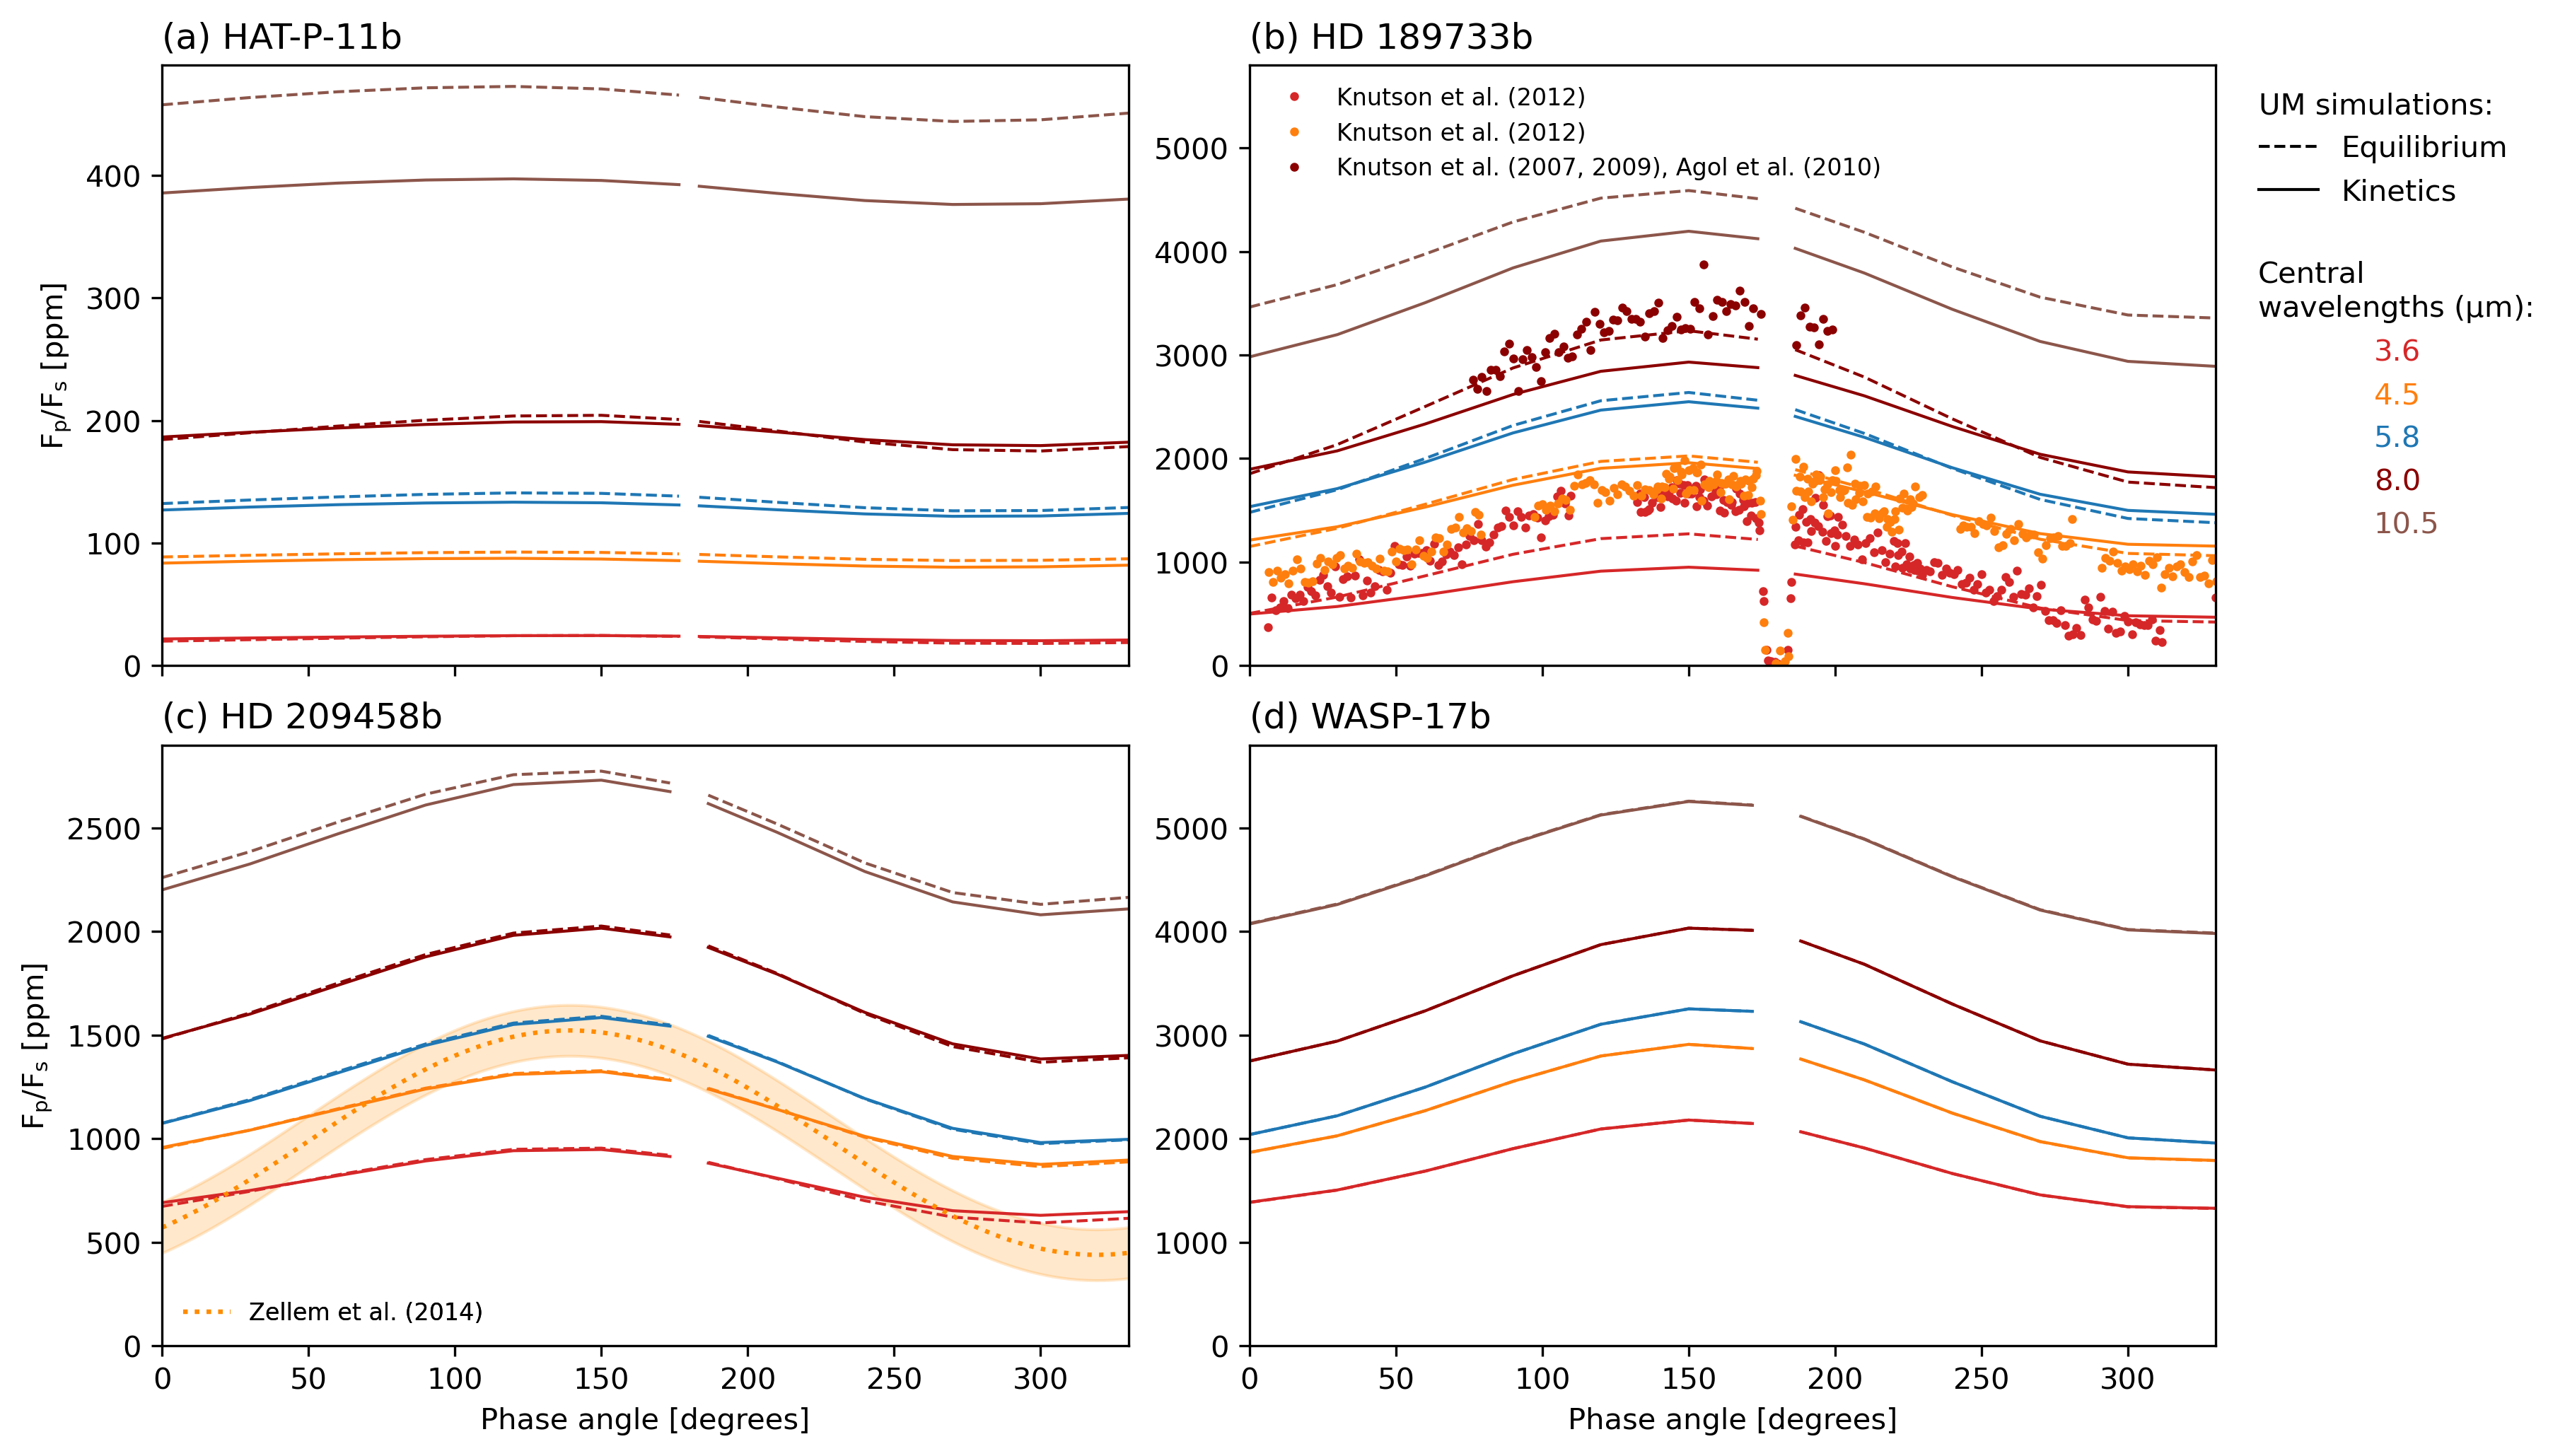

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6.75), constrained_layout=True, sharex=True)
iletters = subplot_label_generator()

to_save = {}
for planet, ax in zip(PLANETS.keys(), axes.flatten()):
    to_save[planet] = {}
    ax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")
    ax.set_xlim(0, 330)
    for exp, linestyle in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
        to_save[planet][exp] = {}
        for band, band_dict in BANDS.items():
            to_save[planet][exp][band] = {}
            # Roll data so that it goes from 0 to 360 degrees
            plt_phase_angs_w_theta = np.insert(
                [
                    i % 360
                    for i in np.delete(
                        np.roll(phase_angs_w_theta[planet]["phase_angs"], -8), [6, 8]
                    )
                ],
                7,
                np.nan,
            )
            plt_phscrv = np.insert(
                np.delete(np.roll(vrbls[planet][exp][band]["phase_curve"].data, -8), [6, 8]),
                7,
                np.nan,
            )
            to_save[planet][exp][band] = {
                "plt_phase_angs_w_theta": plt_phase_angs_w_theta,
                "plt_phscrv": plt_phscrv,
            }
            ax.plot(
                plt_phase_angs_w_theta,
                plt_phscrv,
                label=band,
                color=band_dict["color"],
                linestyle=linestyle,
                linewidth=1,
            )
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Phase angle [degrees]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("$F_p/F_s$ [ppm]")
    if planet == "hatp11b":
        ax.set_ylim(0, 0.00049)
    if planet == "hd189733b":
        hd189733b_plt_kw = {
            "Knutson et al. (2012)": {
                "color": "C3",
                "marker": "o",
                "markersize": 2,
                "linestyle": "None",
            },
            "Knutson et al. (2012) ": {
                "color": "C1",
                "marker": "o",
                "markersize": 2,
                "linestyle": "None",
            },
            "Knutson et al. (2007, 2009), Agol et al. (2010)": {
                "color": "darkred",
                "marker": "o",
                "markersize": 2,
                "linestyle": "None",
            },
        }
        add_custom_legend(ax, hd189733b_plt_kw, frameon=False, loc="upper left", fontsize=8)
        ax.set_ylim(0, 0.0058)
        ax.plot(
            knutson2012_36_x + 180,
            knutson2012_36_y * 1e-2,
            color="C3",
            marker="o",
            markersize=2,
            linestyle="None",
        )
        ax.plot(
            knutson2012_45_x + 180,
            knutson2012_45_y * 1e-2,
            color="C1",
            marker="o",
            markersize=2,
            linestyle="None",
        )
        ax.plot(
            knutson2012_80_x + 180,
            knutson2012_80_y * 1e-2,
            color="darkred",
            marker="o",
            markersize=2,
            linestyle="None",
        )
    if planet == "hd209458b":
        hd209458b_plt_kw = {
            "Zellem et al. (2014)": {
                "color": "darkorange",
                "linestyle": "dotted",
            }
        }
        add_custom_legend(ax, hd209458b_plt_kw, frameon=False, loc="lower left", fontsize=8)
        ax.set_ylim(0, 0.0029)
        ax.plot(
            np.arange(0, 359),
            plt_zellem2014_phase_curve_fit,
            color="darkorange",
            linestyle="dotted",
        )
        ax.fill_between(
            np.arange(0, 359),
            plt_zellem2014_phase_curve_fit_minus,
            plt_zellem2014_phase_curve_fit_plus,
            color="darkorange",
            alpha=0.2,
        )
    if planet == "wasp17b":
        ax.set_ylim(0, 0.0058)
    # Convert y axis labels to ppm
    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter([f"{i:.0f}" for i in ax.get_yticks() * 1e6]))

# Add experiments legend
leg_exp_styles = {
    "equilibrium".capitalize(): {"linestyle": "dashed", "linewidth": 1, "color": "k"},
    "kinetics".capitalize(): {"linestyle": "solid", "linewidth": 1, "color": "k"},
}
leg_exp_kw = {
    "frameon": False,
    "loc": "upper right",
    "bbox_to_anchor": (1.33, 1),
    "title": "UM simulations:",
}
lines_exp = [Line2D([0], [0], **style) for style in leg_exp_styles.values()]
leg_exp = axes[0, 1].legend(lines_exp, leg_exp_styles.keys(), **leg_exp_kw)
if axes[0, 1].legend_ is not None:
    axes[0, 1].add_artist(leg_exp)
for line, text in zip(leg_exp.get_lines(), leg_exp.get_texts()):
    text.set_color(line.get_color())
leg_exp._legend_box.align = "left"

# Add species legend (delete repeating handles and labels)
handles, labels = plt.gca().get_legend_handles_labels()
i = 1
while i < len(labels):
    if labels[i] in labels[:i]:
        del labels[i]
        del handles[i]
    else:
        i += 1
leg_sp = axes[0, 1].legend(
    handles,
    labels,
    frameon=False,
    loc="upper right",
    bbox_to_anchor=(1.355, 0.72),
    handlelength=0,
    title="Central\nwavelengths ($\mu$m):",
)
for line, text in zip(leg_sp.get_lines(), leg_sp.get_texts()):
    text.set_color(line.get_color())
leg_sp.get_title().set_position((0, 0))

figname = f"phase_curves_sum_over_chosen_bands_w_obs.png"
fig.savefig(path_to_results / "synthetic_observations" / "phase_curves" / figname)

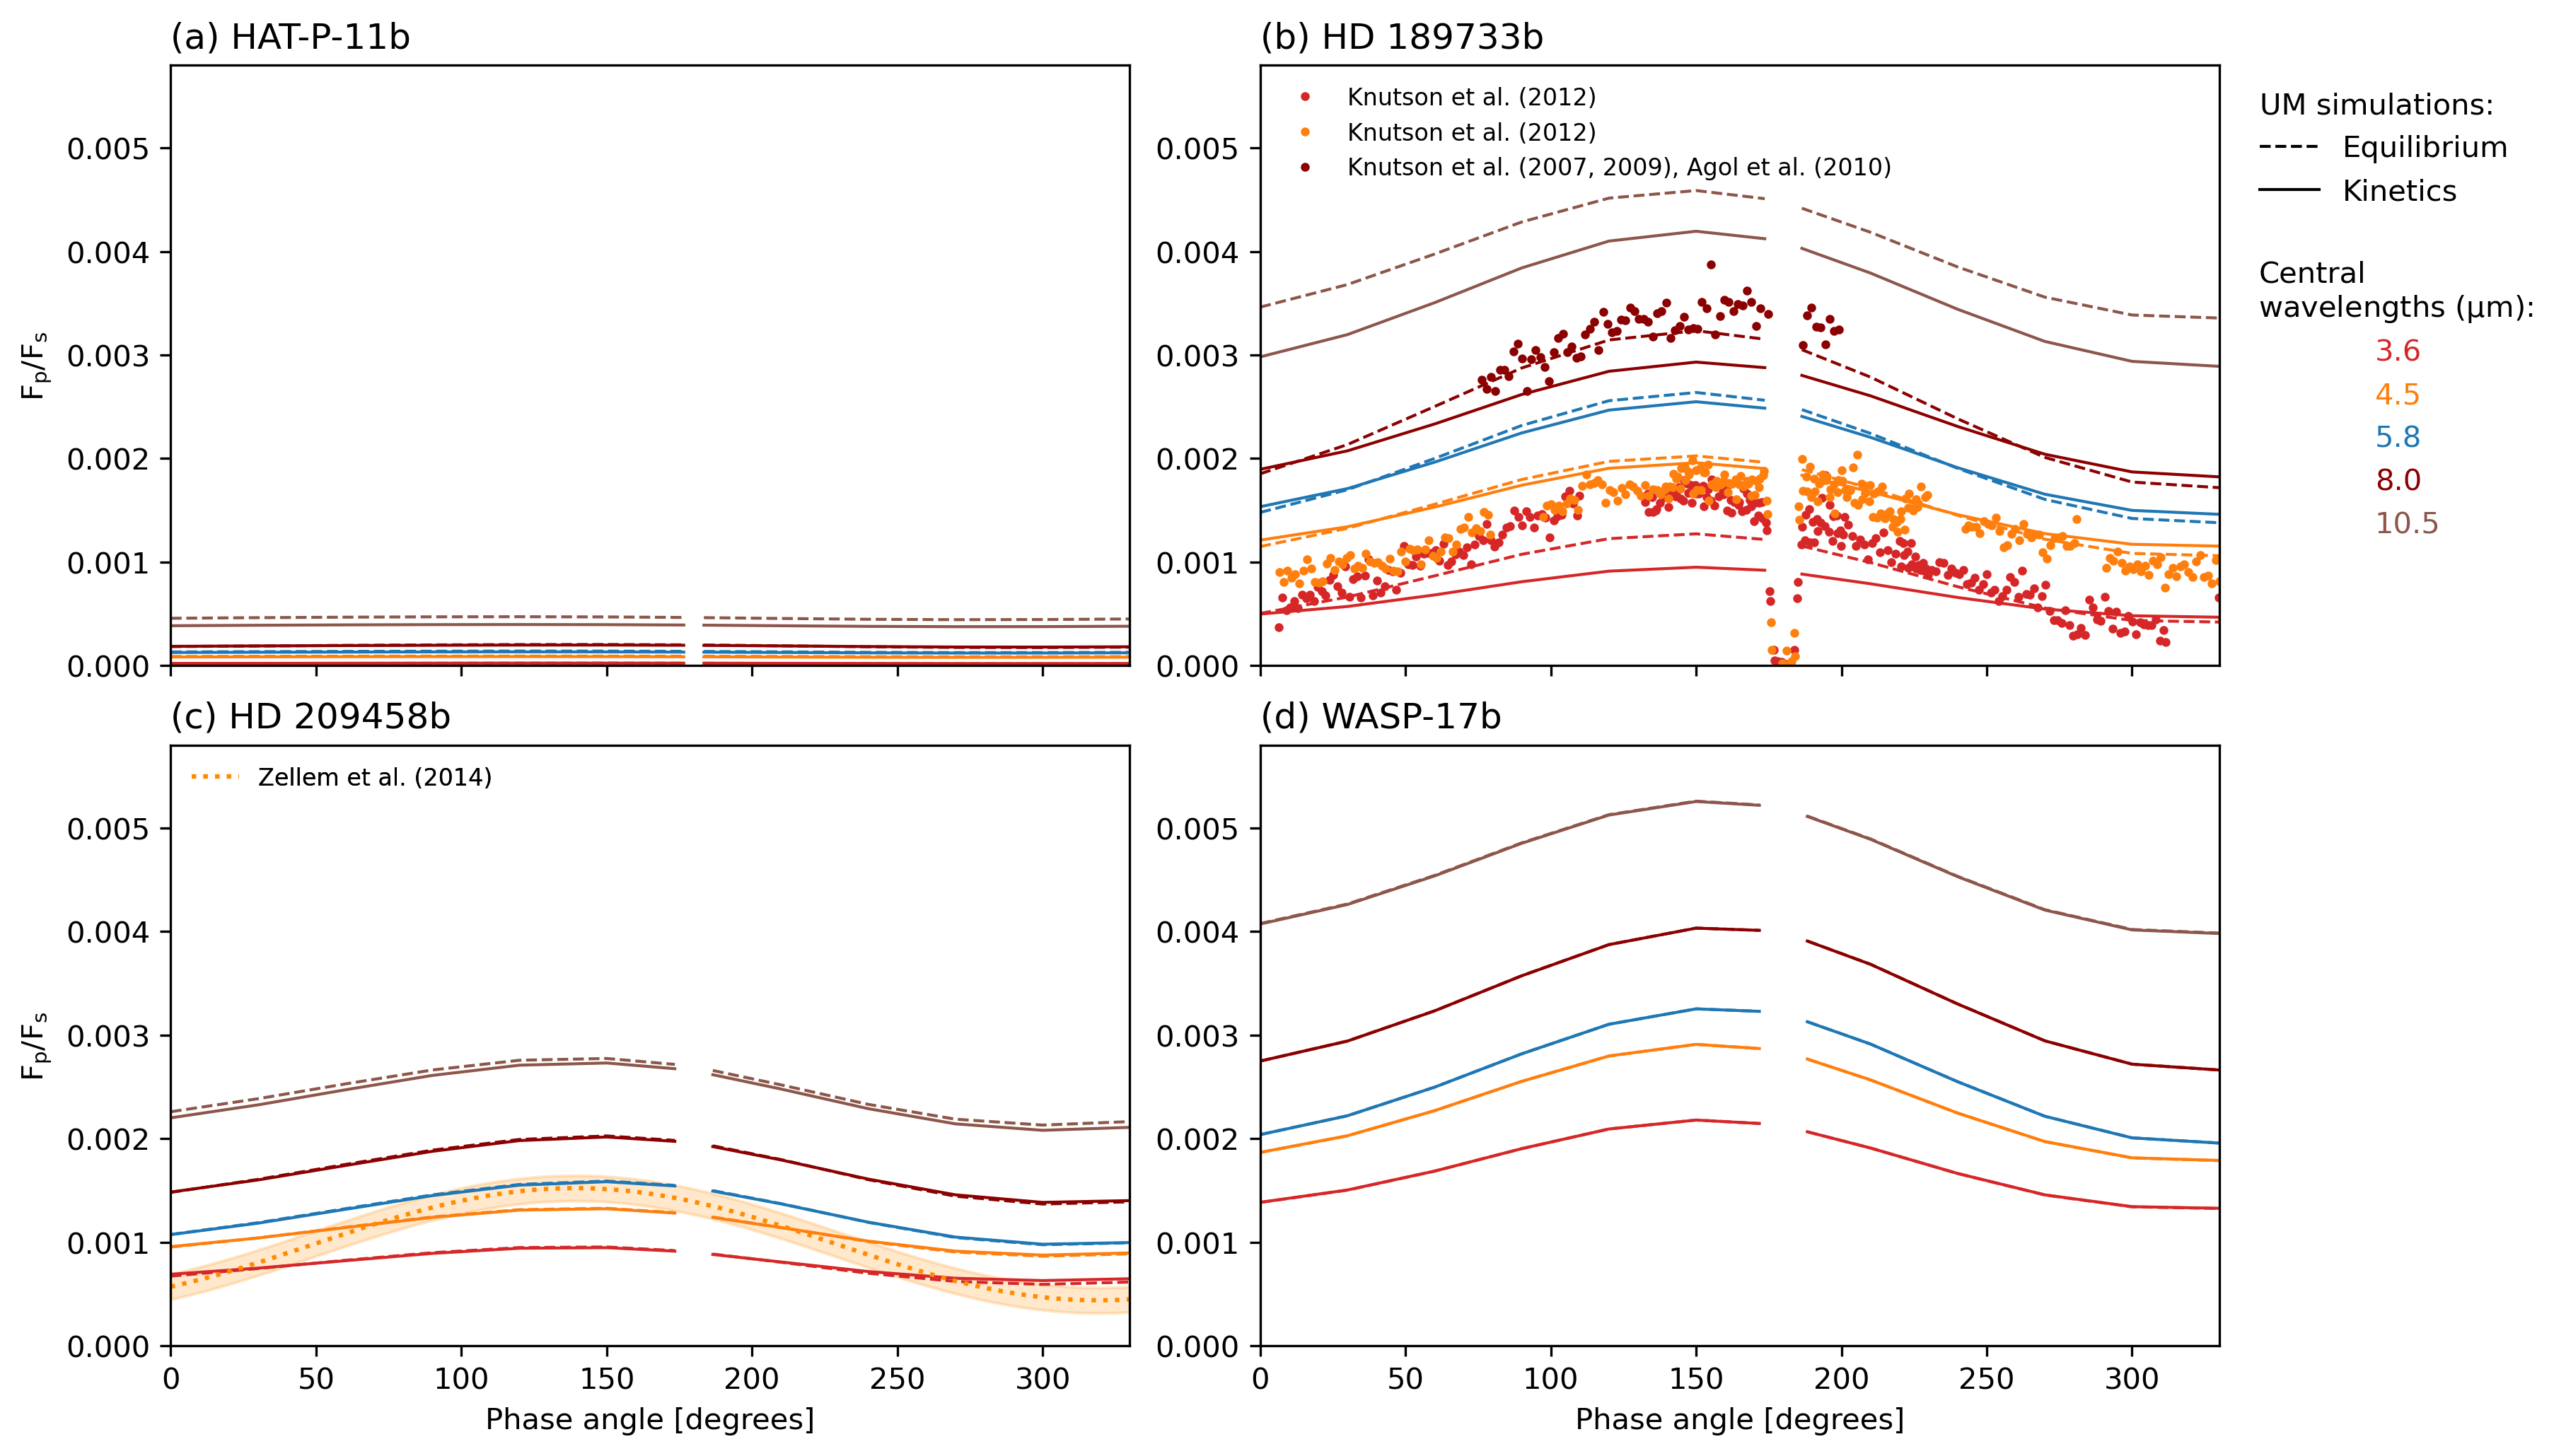

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6.75), constrained_layout=True, sharex=True)
iletters = subplot_label_generator()
for planet, ax in zip(PLANETS.keys(), axes.flatten()):
    ax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")
    ax.set_xlim(0, 330)
    ax.set_ylim(0, 0.0058)
    for exp, linestyle in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
        for band, band_dict in BANDS.items():
            # Roll data so that it goes from 0 to 360 degrees
            plt_phase_angs_w_theta = np.insert(
                [
                    i % 360
                    for i in np.delete(
                        np.roll(phase_angs_w_theta[planet]["phase_angs"], -8), [6, 8]
                    )
                ],
                7,
                np.nan,
            )
            plt_phscrv = np.insert(
                np.delete(np.roll(vrbls[planet][exp][band]["phase_curve"].data, -8), [6, 8]),
                7,
                np.nan,
            )
            ax.plot(
                plt_phase_angs_w_theta,
                plt_phscrv,
                label=band,
                color=band_dict["color"],
                linestyle=linestyle,
                linewidth=1,
            )
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Phase angle [degrees]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("$F_p/F_s$")
    if planet == "hd189733b":
        hd189733b_plt_kw = {
            "Knutson et al. (2012)": {
                "color": "C3",
                "marker": "o",
                "markersize": 2,
                "linestyle": "None",
            },
            "Knutson et al. (2012) ": {
                "color": "C1",
                "marker": "o",
                "markersize": 2,
                "linestyle": "None",
            },
            "Knutson et al. (2007, 2009), Agol et al. (2010)": {
                "color": "darkred",
                "marker": "o",
                "markersize": 2,
                "linestyle": "None",
            },
        }
        add_custom_legend(ax, hd189733b_plt_kw, frameon=False, loc="upper left", fontsize=8)
        ax.plot(
            knutson2012_36_x + 180,
            knutson2012_36_y * 1e-2,
            color="C3",
            marker="o",
            markersize=2,
            linestyle="None",
        )
        ax.plot(
            knutson2012_45_x + 180,
            knutson2012_45_y * 1e-2,
            color="C1",
            marker="o",
            markersize=2,
            linestyle="None",
        )
        ax.plot(
            knutson2012_80_x + 180,
            knutson2012_80_y * 1e-2,
            color="darkred",
            marker="o",
            markersize=2,
            linestyle="None",
        )
    if planet == "hd209458b":
        hd209458b_plt_kw = {
            "Zellem et al. (2014)": {
                "color": "darkorange",
                "linestyle": "dotted",
            }
        }
        add_custom_legend(ax, hd209458b_plt_kw, frameon=False, loc="upper left", fontsize=8)
        ax.plot(
            np.arange(0, 359),
            plt_zellem2014_phase_curve_fit,
            color="darkorange",
            linestyle="dotted",
        )
        ax.fill_between(
            np.arange(0, 359),
            plt_zellem2014_phase_curve_fit_minus,
            plt_zellem2014_phase_curve_fit_plus,
            color="darkorange",
            alpha=0.2,
        )

# Add experiments legend
leg_exp_styles = {
    "equilibrium".capitalize(): {"linestyle": "dashed", "linewidth": 1, "color": "k"},
    "kinetics".capitalize(): {"linestyle": "solid", "linewidth": 1, "color": "k"},
}
leg_exp_kw = {
    "frameon": False,
    "loc": "upper right",
    "bbox_to_anchor": (1.33, 1),
    "title": "UM simulations:",
}
lines_exp = [Line2D([0], [0], **style) for style in leg_exp_styles.values()]
leg_exp = axes[0, 1].legend(lines_exp, leg_exp_styles.keys(), **leg_exp_kw)
if axes[0, 1].legend_ is not None:
    axes[0, 1].add_artist(leg_exp)
for line, text in zip(leg_exp.get_lines(), leg_exp.get_texts()):
    text.set_color(line.get_color())
leg_exp._legend_box.align = "left"

# Add species legend (delete repeating handles and labels)
handles, labels = plt.gca().get_legend_handles_labels()
i = 1
while i < len(labels):
    if labels[i] in labels[:i]:
        del labels[i]
        del handles[i]
    else:
        i += 1
leg_sp = axes[0, 1].legend(
    handles,
    labels,
    frameon=False,
    loc="upper right",
    bbox_to_anchor=(1.355, 0.72),
    handlelength=0,
    title="Central\nwavelengths ($\mu$m):",
)
for line, text in zip(leg_sp.get_lines(), leg_sp.get_texts()):
    text.set_color(line.get_color())
leg_sp.get_title().set_position((0, 0))

figname = f"phase_curves_sum_over_chosen_bands_w_obs_yaxis_same.png"
fig.savefig(path_to_results / "synthetic_observations" / "phase_curves" / figname)

### Save UM phase curves as a dataset

In [15]:
global_attrs = {  # Global metadata
    "title": "Cloud- and haze-free Met Office Unified Model simulations of the atmospheres of HAT-P-11b, HD 189733b, HD 209458b, and WASP-17b.",
    "summary": "This dataset contains the synthetic phase curves obtained from a set of the Met Office Unified Model cloud- and haze-free 1x solar metallicity simulations of the atmospheres of HAT-P-11b, HD 189733b, HD 209458b, and WASP-17b. The dataset includes 8 simulations in total: two simulations (one with the chemical equilibrium scheme and the other with the chemical kinetics scheme) per target. Each simulation was run for a 1000 Earth days. The synthetic phase curves at 3.6, 4.5, 5.8, 8.0 and 10.5 micrometers were obtained during one planetary orbit after day 1000.",
    "conventions": "ACDD-1.3",
    "source": "Met Office Unified Model (UM)",
    "processing_level": "Each synthetic emission phase curve presented here is comprised of the ratios of planetary to stellar flux summed over the range of SOCRATES spectral bands falling within the corresponding Spitzer/IRAC 3.6, 4.5, 5.8, and 8.0 micrometers bandpasses, with the exception of 10.5 micrometers, for which we considered only a single SOCRATES spectral band.",
    "date_created": f"{datetime.utcnow():%Y-%m-%d %H:%M:%S} UTC",
    "creator_name": "Maria Zamyatina",
    "creator_email": "m.zamyatina@exeter.ac.uk",
    "creator_institution": "University of Exeter",
    "coverage_content_type": "modelResult",
}

In [16]:
to_store = {}
for planet in PLANETS.keys():
    to_store[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        to_store[planet][exp] = {}
        for band, band_dict in BANDS.items():
            to_store[planet][exp][band] = {}

            # Remove nan at the secondary eclipse
            arr_phase_angs = np.array(
                [
                    x
                    for x in to_save[planet][exp][band]["plt_phase_angs_w_theta"]
                    if np.isnan(x) == False
                ]
            )
            arr_phscrv = (
                np.array(
                    [x for x in to_save[planet][exp][band]["plt_phscrv"] if np.isnan(x) == False]
                )
                * 1e6
            )
            # Attach arr_phase_angs as cube's dimensional coordinate
            phase_angs_coord = iris.coords.DimCoord(
                arr_phase_angs, long_name="phase_angle", units="degrees"
            )
            cb_phscrv = iris.cube.Cube(arr_phscrv, long_name="phase_curve", units="ppm")
            cb_phscrv.add_dim_coord(phase_angs_coord, data_dim=(0,))

            # Prepare local metadata
            local_attrs = SUITES[planet][exp][metallicity]
            local_attrs["band"] = str(band) + " micrometers"
            # Delete unnecessary local metadata and update planets' names
            local_attrs["planet"] = PLANETS[planet]["tex"]
            entries_to_remove = (
                "initial_pt_profile_file",
                "dir_for_raw",
                "dir_for_merged",
                "dir_for_star_spectrum_lw",
                "dir_for_star_spectrum_sw",
                "dir_for_transmission_day_total",
                "dir_for_transmission_day_ch4",
                "dir_for_transmission_day_co",
                "dir_for_transmission_day_co2",
                "dir_for_transmission_day_h2o",
                "dir_for_transmission_day_hcn",
                "dir_for_transmission_day_nh3",
                "dir_for_transmission_day_h2_h2_cia",
                "dir_for_transmission_day_h2_he_cia",
                "dir_for_transmission_night_total",
                "dir_for_transmission_night_ch4",
                "dir_for_transmission_night_co",
                "dir_for_transmission_night_co2",
                "dir_for_transmission_night_h2o",
                "dir_for_transmission_night_hcn",
                "dir_for_transmission_night_nh3",
                "dir_for_transmission_night_h2_h2_cia",
                "dir_for_transmission_night_h2_he_cia",
                "dir_for_flux_contribution_function_lw",
                "dir_for_phase_curves",
            )
            for k in entries_to_remove:
                local_attrs.pop(k, None)
                if "dir_for_regridded" in local_attrs.keys():
                    local_attrs.pop("dir_for_regridded", None)
            # Merge global and local metadata
            attrs = {**global_attrs, **local_attrs}
            # Add metadata
            cb_phscrv.attributes.update(attrs)

            # Assemble data
            to_store[planet][exp][band] = {
                "dataset": cb_phscrv,
            }

In [17]:
for planet in PLANETS.keys():
    for exp in ["equilibrium", "kinetics"]:
        for band, band_dict in BANDS.items():
            fname = f"met_office_um_phase_curves_{planet}_{exp}_{band}_micrometers.nc"
            iris.save(
                to_store[planet][exp][band]["dataset"],
                str(path_to_datasets / "met_office_um_phase_curves" / fname),
            )

In [18]:
# Zip dataset
shutil.make_archive(
    str(path_to_datasets / "met_office_um_phase_curves"),
    "zip",
    str(path_to_datasets / "met_office_um_phase_curves"),
);